In [84]:
%pip install numpy pandas matplotlib scikit-learn scikit-image seaborn plotly timm albumentations torch torchvision torchaudio colorama segmentation-models-pytorch

In [85]:
import numpy as np
import pandas as pd
# pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os
from tqdm import tqdm
tqdm.pandas()

from dataclasses import dataclass


# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Optimizer


# Albumentations for augmentations
import albumentations as A
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.pytorch import ToTensorV2


# Add Monitoring and Logging
import wandb
from datetime import datetime

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import userdata
WANDB_API_KEY = userdata.get('WANDB_API_KEY')
if not WANDB_API_KEY:
    raise ValueError("WANDB_API_KEY environment variable is not set.")

# ⚙️ Configuration

In [86]:


@dataclass
class CFG:
    seed          = 2025
    backbone      = "efficientnet-b3"# "efficientnet-b3" # se_resnext101_32x4d - se_resnext50_32x4d - efficientnet-b3  timm-resnest101e
    decoder_attention_type = "scse"
    train_bs      = 3
    valid_bs      = train_bs*2
    img_size      = [1536, 786]
    crop_size     = [512, 512]
    epochs        = 40# 40
    lr            = 1e-4
    max_grad_norm = 100
    scheduler     = "ReduceLROnPlateau" #'OneCycle' # ReduceLROnPlateau CosineAnnealingLR CustomCosineAnnealingWarmupRestarts
    min_lr        = 5e-5
    T_max         = int(17000/train_bs*epochs)+50
    T_0           = 25
    max_lr        = 4e-4
    warmup_epochs = 0
    wd            = 5e-6
    n_accumulate  = 1
    n_fold        = 4
    folds         = [0, 1, 2, 3]
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    aux_head      = False
    thresh        = [0.3, 0.4, 0.5, 0.6, 0.7]


In [87]:
# Initialize W&B run
wandb.login(key=WANDB_API_KEY)
run = wandb.init(
    project="tumor-segmentation",
    entity="nm-i-ki",
    name=f"train_unet_kfold_tta_{datetime.now():%Y%m%d_%H%M%S}",
    config={
        "seed": CFG.seed,
        "backbone": CFG.backbone,
        "decoder_attention_type": CFG.decoder_attention_type,
        "train_bs": CFG.train_bs,
        "valid_bs": CFG.valid_bs,
        "img_size": CFG.img_size,
        "crop_size": CFG.crop_size,
        "epochs": CFG.epochs,
        "lr": CFG.lr,
        "max_grad_norm": CFG.max_grad_norm,
        "scheduler": CFG.scheduler,
        "min_lr": CFG.min_lr,
        "T_max": CFG.T_max,
        "T_0": CFG.T_0,
        "max_lr": CFG.max_lr,
        "warmup_epochs": CFG.warmup_epochs,
        "wd": CFG.wd,
        "n_accumulate": CFG.n_accumulate,
        "n_fold": CFG.n_fold,
        "folds": CFG.folds,
        "num_classes": CFG.num_classes,
        "aux_head": CFG.aux_head,
        "thresh": CFG.thresh,
    },
    tags=["segmentation", "efficientnet"],
    save_code=True,
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇██
val_dice,▁
val_loss,▁
epoch,1
train_loss,289.39428
val_dice,0.16163
val_loss,0.2678


# ❗ Reproducibility

In [88]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('-> SEEDING DONE')

set_seed(CFG.seed)

-> SEEDING DONE


In [89]:
from google.colab import drive
drive.mount('/content/drive')
CONTROLS_DIR = "/content/drive/MyDrive/data/raw/tumor-segmentation/controls/"
PATIENTS_DIR = "/content/drive/MyDrive/data/raw/tumor-segmentation/patients"

rows = []
data_df = pd.DataFrame(columns=['image_id', 'image_path', 'label_path', 'label'])

# Load the control images
control_images = glob(os.path.join(CONTROLS_DIR, "imgs", "*.png"))
for img_path in control_images:
    image_id = os.path.basename(img_path).split('/')[-1]
    rows.append({'image_id': image_id, 'image_path': f'{CONTROLS_DIR}/imgs/{image_id}', 'label_path': '', 'label': 0})

# Load the patient images
patient_images = glob(os.path.join(PATIENTS_DIR, "imgs", "*.png"))
segmentation_labels = glob(os.path.join(PATIENTS_DIR, "labels", "*.png"))
for img_path, label_path in zip(patient_images, segmentation_labels):
    image_id = os.path.basename(img_path).split('/')[-1]
    label_id = image_id.replace('patient', 'segmentation')
    rows.append({'image_id': image_id, 'image_path': f'{PATIENTS_DIR}/imgs/{image_id}', 'label_path': f'{PATIENTS_DIR}/labels/{label_id}', 'label': 1})

data_df = pd.DataFrame(rows)
data_df = data_df.reset_index(drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Class Distribution

In [90]:
df = data_df.copy()
df['label'].value_counts()

,count
label,
0,426
1,182


# 🔨 Utility

In [91]:
def load_img(image_path, mask_path, scale = True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (CFG.img_size[1], CFG.img_size[0]), interpolation=cv2.INTER_LINEAR)
    if mask_path == "":
        mask = np.zeros_like(img, dtype=np.uint8)
    else:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (CFG.img_size[1], CFG.img_size[0]), interpolation=cv2.INTER_LINEAR)
        mask = (mask > 0).astype(np.uint8)

    img = np.expand_dims(img.astype("float32"), axis=-1)
    mask = np.expand_dims(mask.astype("float32"), axis=-1)
    if scale:
        img = (img - img.min()) / (img.max() - img.min())
        # img = (img - img.mean()) / img.std()
    assert img.shape == mask.shape, f"Image shape {img.shape} does not match mask shape {mask.shape}"
    return img, mask


def get_dice(preds, masks, threshold=0.5, epsilon=1e-6):
    """
    Compute per-image Dice coefficient and return the mean across the batch.

    preds, masks: np.ndarray of shape (B, H, W) or (B, 1, H, W)
    """
    preds = (preds > threshold).astype(np.uint8)
    masks = (masks > threshold).astype(np.uint8)

    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds[:, 0]
        masks = masks[:, 0]

    intersection = (preds & masks).sum(axis=(1, 2))
    total = preds.sum(axis=(1, 2)) + masks.sum(axis=(1, 2))

    dice_scores = (2.0 * intersection + epsilon) / (total + epsilon)
    return dice_scores.mean()



# 📁 Create Folds

In [92]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold,(train_idx, val_idx) in enumerate(skf.split(df, df['label'], df['image_id'])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','label'])['image_id'].count())

fold  label
0.0   0        107
      1         45
1.0   0        107
      1         45
2.0   0        106
      1         46
3.0   0        106
      1         46
Name: image_id, dtype: int64

# 🍚 Dataset

In [93]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self,
                 df,
                 transforms=None):

        self.df           = df.reset_index(drop=True)
        self.transforms   = transforms
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.image_path[index]
        label_path = self.df.label_path[index]

        ## Load the image (RGB)
        img, mask = load_img(img_path, label_path, True)
        ## Apply Augmentations:
        if self.transforms:
            data = self.transforms(image=img, mask=mask)
            img  = data['image']
            mask = data['mask']
            img = np.transpose(img, (2, 0, 1))
        else:
            img = np.transpose(img, (2, 0, 1))

        mask = np.transpose(mask, (2, 0, 1))

        # if CFG.aux_head and self.label:
        #     labels = np.where(mask.sum((1, 2)) > 0, 1, 0)
        # else:
        #     labels = mask
        img = torch.tensor(img)
        mask = torch.tensor(mask)
        return torch.tensor(img), torch.tensor(mask), img_path


class TTADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, tta_transforms):
        self.base_dataset = base_dataset
        self.tta_transforms = tta_transforms

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, mask, img_path = self.base_dataset[idx]

        image = image.permute(1, 2, 0).numpy()

        all_aug_images = []
        for t in self.tta_transforms:
            aug = t(image=image)['image']
            aug = torch.from_numpy(aug).permute(2, 0, 1).float()  # back to CHW
            all_aug_images.append(aug)

        return torch.stack(all_aug_images), mask, img_path

# Augmentations

In [94]:
# A custom transform to pad images and masks to be divisible by a given number.
# This is a DualTransform, meaning it applies the same operation to both the image and mask.
class PadToDivisible(A.DualTransform):
    def __init__(self, divisible=32, value=0, mask_value=0, always_apply=True, p=1.0):
        """
        Initializes the PadToDivisible transform.

        Args:
            divisible (int): The number to which the image dimensions should be padded to be divisible by.
            value (int): The value to use for padding the image.
            mask_value (int): The value to use for padding the mask.
            always_apply (bool): Whether to always apply the transform.
            p (float): The probability of applying the transform.
        """
        super().__init__(always_apply, p)
        self.divisible = divisible
        self.value = value
        self.mask_value = mask_value

    def get_params(self):
        """
        This method is for parameters that are independent of the input targets.
        Since this transform's parameters depend on the image size, we return an empty dictionary.
        """
        return {}

    def _get_padding_params(self, h, w):
        """
        Helper method to calculate padding parameters.
        """
        pad_h = (self.divisible - h % self.divisible) % self.divisible
        pad_w = (self.divisible - w % self.divisible) % self.divisible

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        return pad_top, pad_bottom, pad_left, pad_right

    def apply(self, img, **params):
        """
        Applies padding to the image.

        Args:
            img (np.ndarray): The input image.

        Returns:
            np.ndarray: The padded image.
        """
        h, w = img.shape[:2]
        pad_top, pad_bottom, pad_left, pad_right = self._get_padding_params(h, w)

        if img.ndim == 3:
            return np.pad(
                img,
                ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                mode='constant',
                constant_values=self.value,
            )
        else:
            return np.pad(
                img,
                ((pad_top, pad_bottom), (pad_left, pad_right)),
                mode='constant',
                constant_values=self.value,
            )

    def apply_to_mask(self, mask, **params):
        """
        Applies padding to the mask.

        Args:
            mask (np.ndarray): The input mask.

        Returns:
            np.ndarray: The padded mask.
        """
        h, w = mask.shape[:2]
        pad_top, pad_bottom, pad_left, pad_right = self._get_padding_params(h, w)

        if mask.ndim == 3:
            return np.pad(
                mask,
                ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                mode='constant',
                constant_values=self.mask_value,
            )
        else:
            return np.pad(
                mask,
                ((pad_top, pad_bottom), (pad_left, pad_right)),
                mode='constant',
                constant_values=self.mask_value,
            )

    def get_transform_init_args_names(self):
        """
        Returns a tuple of the names of the parameters passed to __init__.
        This is for serialization/deserialization.
        """
        return ('divisible', 'value', 'mask_value')

In [95]:
data_transforms = {"train": A.Compose([A.HorizontalFlip(p=0.5),
                                       A.VerticalFlip(p=0.5),
                                    #    A.ShiftScaleRotate(rotate_limit=25, scale_limit=0.15, shift_limit=0, p=0.25),
#                                        A.CoarseDropout(max_holes=16, max_height=64 ,max_width=64 ,p=0.5),
#                                        A.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25, p=0.75),
#                                        A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, p=0.5),
                                       A.RandomCrop(height=CFG.img_size[0], width=CFG.img_size[1], always_apply=True, p=1)
                                        ]),

                    "valid": A.Compose([]),#PadToDivisible(divisible=32, always_apply=True, p=1.0),

                    "tta": [
                        A.Compose([]),  # identity
                        A.HorizontalFlip(p=1.0),
                        A.VerticalFlip(p=1.0)
                     ]
                    }

# DataLoader

In [96]:
def prepare_loaders(fold, non_empty=False):
    train_df = df[df.fold != fold].reset_index(drop=True)
    valid_df = df[df.fold == fold].reset_index(drop=True)

    if non_empty:
        train_df = train_df[train_df['label'] == 0].reset_index(drop=True)
        valid_df = valid_df[valid_df['label'] == 0].reset_index(drop=True)

    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    # Wrap the validation dataset in a deterministic TTA wrapper
    base_oof_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])
    oof_dataset = TTADataset(base_oof_dataset, tta_transforms=data_transforms['tta'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs,
                              num_workers=8, shuffle=True, pin_memory=True, drop_last=False)

    valid_loader = DataLoader(valid_dataset, batch_size=1,
                              num_workers=8, shuffle=False, pin_memory=True)

    oof_loader = DataLoader(oof_dataset, batch_size=1,  # returns [1, T, C, H, W]
                            num_workers=8, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, oof_loader, len(train_df) // CFG.train_bs, valid_df

In [97]:
train_loader, valid_loader, oof_loader, training_steps, valid_df = prepare_loaders(fold=0)

In [98]:
imgs, masks, path_ = next(iter(train_loader))

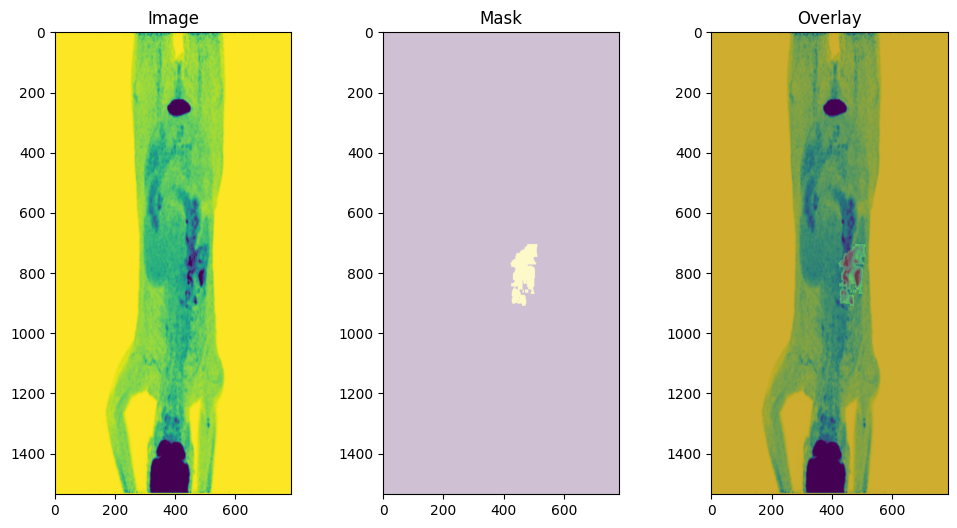

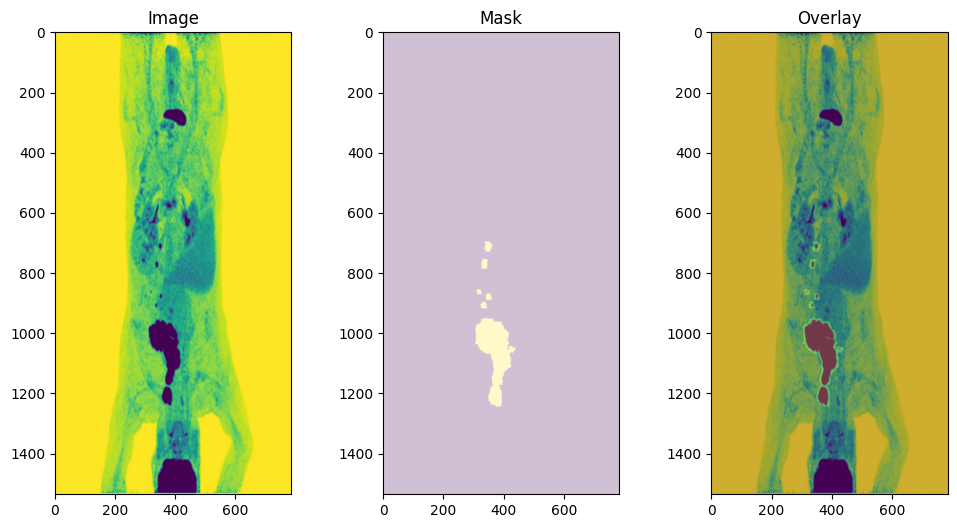

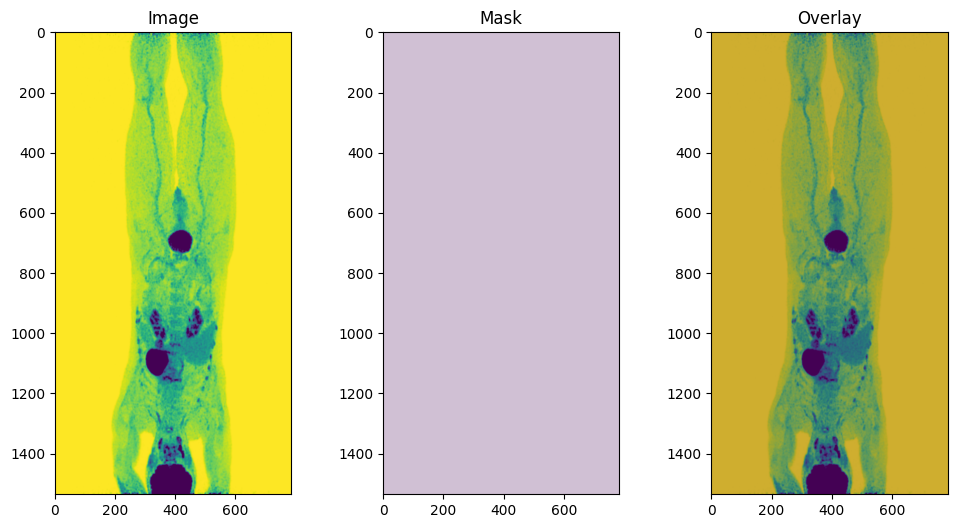

In [99]:
for i in range(imgs.shape[0]):
    #make the image and mask two suplots horizontally with third image overlaying them together
    _img = np.transpose(imgs[i].cpu().numpy(), (1, 2, 0))
    mask = np.transpose(masks[i].cpu().numpy(), (1, 2, 0))
    fig, ax = plt.subplots(1,3, figsize=(12, 6))
    ax[0].imshow(_img)
    ax[0].set_title("Image")
    ax[1].imshow(mask, alpha = 0.25)
    ax[1].set_title("Mask")
    ax[2].imshow(_img)
    ax[2].imshow(mask, alpha = 0.25)
    ax[2].set_title("Overlay")
    plt.show()

In [100]:
imgs, msks, paths_ = next(iter(valid_loader))

1.0 0.0
[0.]


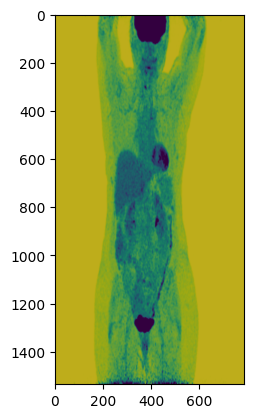

In [101]:
for i in range(imgs.shape[0]):
    _img = np.transpose(imgs[i].cpu().numpy(), (1, 2, 0))
    _mask = np.transpose(msks[i].cpu().numpy(), (1, 2, 0))
    print(_img.max(), _img.min())
    print(np.unique(_mask))
    plt.imshow(_img)
    plt.imshow(_mask, alpha = 0.25, cmap = 'gray')
    plt.show()

In [102]:
import gc
gc.collect()

20888

# 📦 Model

In [103]:


def build_model():
    model = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                     classes=1,                      # model output channels (number of classes in your dataset)
                     activation=None,
                     decoder_attention_type = CFG.decoder_attention_type, #"scse",
                     aux_params = None if not CFG.aux_head else {"classes": 1,
                                                                 "activation": None})
    model.to(CFG.device)
    return model


def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔧 Loss Function

In [104]:
JaccardLoss    = smp.losses.JaccardLoss(mode='binary')
DiceLoss       = smp.losses.DiceLoss(mode='binary')
BCELoss        = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss     = smp.losses.LovaszLoss(mode='binary', per_image=False)
TverskyLoss    = smp.losses.TverskyLoss(mode='binary', log_loss=False, smooth=0.1)
SegFocalLoss   = smp.losses.FocalLoss(mode = 'binary')
BCE = torch.nn.BCEWithLogitsLoss()

def dice_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=1e-6):
    y_true = y_true.float()
    y_pred = (y_pred > thr).float()
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = (2 * inter + epsilon) / (den + epsilon)
    return dice.mean()  # mean over batch (and channel if present)


def iou_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=1e-6):
    y_true = y_true.float()
    y_pred = (y_pred > thr).float()
    inter = (y_true * y_pred).sum(dim=dim)
    union = y_true.sum(dim=dim) + y_pred.sum(dim=dim) - inter
    iou = (inter + epsilon) / (union + epsilon)
    return iou.mean()  # mean over batch


def criterion(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

# def criterion(y_pred, y_true):
#     if CFG.aux_head:
#         y_true, yt_class = y_true
#         y_pred, yp_class = y_pred
#         return (0.5*DiceLoss(y_pred, y_true) + 0.5 * BCE(yp_class, yt_class))
#     return 0.5*DiceLoss(y_pred, y_true) + 0.5*SegFocalLoss(y_pred, y_true)

# 🚄 Training Function

In [105]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch:int):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    train_jaccards = []
    train_dices = []

    sigmoid = torch.sigmoid  # Faster than instantiating nn.Sigmoid()

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')

    optimizer.zero_grad()

    for step, (images, masks, paths) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)
        loss.backward()

        y_pred = sigmoid(y_pred)

        train_dice = dice_coef(masks, y_pred).cpu().item()
        train_jaccard = iou_coef(masks, y_pred).cpu().item()
        train_dices.append(train_dice)
        train_jaccards.append(train_jaccard)

        if (step + 1) % CFG.n_accumulate == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler and CFG.scheduler not in ["ReduceLROnPlateau", "ExponentialLR"]:
                scheduler.step()

        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        wandb.log({'train_loss': running_loss, 'epoch': epoch})
        # W&B per-epoch training metrics
        current_lr = optimizer.param_groups[0]['lr']
        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0

        pbar.set_postfix(loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         jac=np.mean(train_jaccards),
                         dice=np.mean(train_dices),
                         gpu_mem=f'{mem:0.2f} GB')

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, np.mean(train_dices), np.mean(train_jaccards)


# 👀 Validation Function

In [106]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, optimizer, epoch:int):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    global_masks = []
    global_preds = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')

    for step, (images, masks, paths) in pbar:
        images = images.float().to(device)
        masks = masks.float().to(device)
        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = torch.sigmoid(y_pred)
        global_masks.append(masks.cpu().numpy())
        global_preds.append(y_pred.detach().cpu().numpy())

        current_lr = optimizer.param_groups[0]['lr']
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_mem=f'{mem:0.2f} GB')

    # For sample images, take first example of last batch
    # Concatenate all batches
    global_masks = np.concatenate(global_masks, axis=0)
    global_preds = np.concatenate(global_preds, axis=0)
    global_dice = get_dice(global_preds, global_masks)

    # Log overall validation metrics
    wandb.log({'val_loss': epoch_loss, 'val_dice': global_dice, 'epoch': epoch})

    # For sample images, take first example of last batch
    img_np = images[0].cpu().permute(1,2,0).numpy()
    mask_np = masks[0].cpu().permute(1,2,0).numpy()
    pred_np = global_preds[-1][0].astype('float32') # Remove transpose as it's a single channel
    wandb.log({
        'input': wandb.Image(img_np, caption='input'),
        'mask': wandb.Image(mask_np, caption='mask'),
        'pred': wandb.Image(pred_np, caption='pred'),
        'epoch': epoch
    })

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, global_dice

In [107]:
def reverse_transform(pred, transform_type):
    if transform_type == "hflip":
        return np.fliplr(pred)
    elif transform_type == "vflip":
        return np.flipud(pred)
    elif transform_type == "identity":
        return pred
    else:
        raise ValueError(f"Unknown TTA transform: {transform_type}")

@torch.no_grad()
def oof_one_epoch(model, dataloader, device, valid_df, fold, tta_transform_names):
    model.eval()

    oof_scores = []
    global_preds = []
    global_masks = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='OOF Eval')

    for step, (tta_images, masks, img_path) in pbar:
        tta_images = tta_images.squeeze(0).to(device).float()
        masks = masks.squeeze(0).to(device).float()
        img_path = img_path[0] if isinstance(img_path, list) else img_path
        img_path = str(img_path)  # ensure string for merging

        preds = model(tta_images)
        preds = torch.sigmoid(preds).squeeze(1).cpu().numpy()
        masks_np = masks.squeeze().cpu().numpy()

        aligned_preds = []
        for pred, tname in zip(preds, tta_transform_names):
            aligned_preds.append(reverse_transform(pred, tname))

        aligned_preds = np.stack(aligned_preds, axis=0)
        tta_avg_pred = aligned_preds.mean(axis=0)
        base_pred = aligned_preds[0]

        base_dice = get_dice(base_pred[None], masks_np[None])
        tta_dice = get_dice(tta_avg_pred[None], masks_np[None])

        global_preds.append(tta_avg_pred[None])
        global_masks.append(masks_np[None])

        oof_scores.append({
            'image_path': img_path,
            'base_dice': base_dice,
            'tta_dice': tta_dice
        })

        pbar.set_postfix(base_dice=f'{base_dice:.4f}', tta_dice=f'{tta_dice:.4f}')

    df_scores = pd.DataFrame(oof_scores)

    # Merge on image_path instead of index
    valid_df = valid_df.copy()
    valid_df = valid_df.merge(df_scores, on='image_path', how='left')
    valid_df.to_csv(f'tta_results_fold_{fold}.csv', index=False)

    global_preds = np.concatenate(global_preds, axis=0)
    global_masks = np.concatenate(global_masks, axis=0)
    global_dice = get_dice(global_preds, global_masks)

    torch.cuda.empty_cache()
    gc.collect()

    return global_dice, valid_df

# 🏃 Run Training

In [108]:
from collections import defaultdict
import time
import copy
import torch
import gc
import numpy as np
import os # Import the os module

def run_training(model, optimizer, scheduler, num_epochs, train_loader, valid_loader, fold=0):
    if torch.cuda.is_available():
        print(f"CUDA: {torch.cuda.get_device_name()}\n")

    # Create the 'models' directory if it doesn't exist
    os.makedirs('models', exist_ok=True)

    wandb.watch(model, log='all', log_freq=10)

    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f"{'='*30}\nEpoch {epoch}/{num_epochs}")

        train_loss, train_dice, train_jaccard = train_one_epoch(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            dataloader=train_loader,
            device=CFG.device,
            epoch=epoch,
        )

        val_loss, val_dice = valid_one_epoch(
            model=model,
            dataloader=valid_loader,
            device=CFG.device,
            optimizer=optimizer,
            epoch=epoch
        )

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)

        print(f"Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f} - Train Jaccard: {train_jaccard:.4f} | Valid Loss: {val_loss:.4f} | Valid Dice: {val_dice:.4f}")

        # Save best model
        if val_dice > best_dice:
            print(f"✓ Dice Improved: {best_dice:.4f} → {val_dice:.4f}")
            best_dice = val_dice
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

            best_path = f'models/best_fold{fold}_dice{best_dice:.4f}.pth'
            torch.save(model.state_dict(), best_path)
            print(f"✔ Model saved to {best_path}")
            # W&B artifact
            artifact = wandb.Artifact(f'best_model_fold{fold}', type='model')
            artifact.add_file(best_path)
            run.log_artifact(artifact)

        # Always save last epoch
        last_path = f"last_epoch-S1-{fold:02d}.bin"
        torch.save(model.state_dict(), last_path)

        # Step scheduler if applicable
        if CFG.scheduler in ["ReduceLROnPlateau", "ExponentialLR"]:
            if CFG.scheduler == "ExponentialLR":
                scheduler.step()
            elif CFG.scheduler == "ReduceLROnPlateau":
                scheduler.step(val_loss)

        print()

    elapsed = time.time() - start_time
    h, m, s = int(elapsed // 3600), int((elapsed % 3600) // 60), int(elapsed % 60)
    print(f"🏁 Training complete in {h}h {m}m {s}s")
    print(f"🏆 Best Dice: {best_dice:.4f} (Epoch {best_epoch})")

    model.load_state_dict(best_model_wts)
    return model, history

In [109]:
def fetch_scheduler(optimizer: Optimizer, training_steps: int = 0):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                   T_max=training_steps*CFG.epochs,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                             T_0=training_steps*8,
                                                             T_mult = 1,
                                                             eta_min=CFG.min_lr)

    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='max',
                                                   factor=0.5,
                                                   patience=1,
                                                   cooldown=1,
                                                   min_lr=5e-6,
                                                   threshold=0.00001,)
    elif CFG.scheduler == 'OneCycle':
        scheduler = lr_scheduler.OneCycleLR(optimizer,
                                            max_lr = CFG.max_lr,
                                            total_steps=training_steps*CFG.epochs,
#                                             epochs=CFG.epochs,
#                                             steps_per_epoch=training_steps,
                                            pct_start=0.25)
    elif CFG.scheduler == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    elif CFG.scheduler == None:
        return None

    return scheduler

# 🚅 Training

In [ ]:
oof_dice_scores = []
all_oof_dfs = []
tta_transform_names = ["identity", "hflip", "vflip"]

for fold in CFG.folds:
    print(f'\n{"#"*30}\n##### Fold {fold}\n{"#"*30}\n')
    run.name = f"fold{fold}_{datetime.now():%Y%m%d_%H%M%S}"
    model = build_model()

    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=0.05)
    CFG.scheduler = "CosineAnnealingLR"

    # Loaders for this fold (train + valid + TTA OOF)
    train_loader, valid_loader, oof_loader, train_steps, valid_df = prepare_loaders(
        fold=fold,
        non_empty=False,
    )

    scheduler = fetch_scheduler(optimizer, train_steps)

    # Train model
    model, _ = run_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=CFG.epochs,
        train_loader=train_loader,
        valid_loader=valid_loader,
        fold=fold
    )

    model = load_model(f"best_epoch-S1-{fold:02d}.bin")
    # TTA-based OOF prediction
    oof_dice, valid_df_with_scores = oof_one_epoch(
        model=model,
        dataloader=oof_loader,
        device=CFG.device,
        valid_df=valid_df,
        fold=fold,
        tta_transform_names=tta_transform_names
    )

    print(f"✅ Fold {fold} OOF Dice: {oof_dice:.4f}")

    oof_dice_scores.append(oof_dice)
    all_oof_dfs.append(valid_df_with_scores)

# Final average OOF Dice
mean_oof_dice = np.mean(oof_dice_scores)
print(f"\n{'='*40}\n🏁 Final OOF Dice across all folds: {mean_oof_dice:.4f}")

# Save full OOF dataframe
final_oof_df = pd.concat(all_oof_dfs, ignore_index=True)
final_oof_df.to_csv("oof_scores_all_folds.csv", index=False)

# Finish W&B
run.finish()



##############################
##### Fold 0
##############################

CUDA: NVIDIA L4

Epoch 1/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.96it/s, gpu_mem=1.41 GB, lr=0.00010, valid_loss=0.2657]


Train Loss: 0.6351 - Train Dice: 0.0481 - Train Jaccard: 0.0288 | Valid Loss: 0.2657 | Valid Dice: 0.1523
✓ Dice Improved: -inf → 0.1523
✔ Model saved to models/best_fold0_dice0.1523.pth

Epoch 2/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.97it/s, gpu_mem=1.40 GB, lr=0.00010, valid_loss=0.2462]


Train Loss: 0.6220 - Train Dice: 0.1019 - Train Jaccard: 0.0691 | Valid Loss: 0.2462 | Valid Dice: 0.1755
✓ Dice Improved: 0.1523 → 0.1755
✔ Model saved to models/best_fold0_dice0.1755.pth

Epoch 3/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, gpu_mem=1.40 GB, lr=0.00010, valid_loss=0.2024]


Train Loss: 0.5881 - Train Dice: 0.1662 - Train Jaccard: 0.1272 | Valid Loss: 0.2024 | Valid Dice: 0.1489

Epoch 4/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.90it/s, gpu_mem=1.40 GB, lr=0.00010, valid_loss=0.1320]


Train Loss: 0.4833 - Train Dice: 0.2728 - Train Jaccard: 0.2340 | Valid Loss: 0.1320 | Valid Dice: 0.5671
✓ Dice Improved: 0.1755 → 0.5671
✔ Model saved to models/best_fold0_dice0.5671.pth

Epoch 5/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.75it/s, gpu_mem=1.42 GB, lr=0.00010, valid_loss=0.1235]


Train Loss: 0.3858 - Train Dice: 0.4296 - Train Jaccard: 0.3921 | Valid Loss: 0.1235 | Valid Dice: 0.5998
✓ Dice Improved: 0.5671 → 0.5998
✔ Model saved to models/best_fold0_dice0.5998.pth

Epoch 6/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, gpu_mem=1.42 GB, lr=0.00010, valid_loss=0.1140]


Train Loss: 0.3025 - Train Dice: 0.4130 - Train Jaccard: 0.3757 | Valid Loss: 0.1140 | Valid Dice: 0.4868

Epoch 7/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.96it/s, gpu_mem=1.42 GB, lr=0.00010, valid_loss=0.2204]


Train Loss: 0.3054 - Train Dice: 0.5219 - Train Jaccard: 0.4849 | Valid Loss: 0.2204 | Valid Dice: 0.6808
✓ Dice Improved: 0.5998 → 0.6808
✔ Model saved to models/best_fold0_dice0.6808.pth

Epoch 8/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.94it/s, gpu_mem=1.43 GB, lr=0.00010, valid_loss=0.0900]


Train Loss: 0.2923 - Train Dice: 0.4423 - Train Jaccard: 0.4064 | Valid Loss: 0.0900 | Valid Dice: 0.6630

Epoch 9/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.91it/s, gpu_mem=1.43 GB, lr=0.00009, valid_loss=0.1179]


Train Loss: 0.2309 - Train Dice: 0.5769 - Train Jaccard: 0.5401 | Valid Loss: 0.1179 | Valid Dice: 0.7000
✓ Dice Improved: 0.6808 → 0.7000
✔ Model saved to models/best_fold0_dice0.7000.pth

Epoch 10/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.79it/s, gpu_mem=1.43 GB, lr=0.00009, valid_loss=0.0856]


Train Loss: 0.2369 - Train Dice: 0.5261 - Train Jaccard: 0.4893 | Valid Loss: 0.0856 | Valid Dice: 0.7001
✓ Dice Improved: 0.7000 → 0.7001
✔ Model saved to models/best_fold0_dice0.7001.pth

Epoch 11/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.93it/s, gpu_mem=1.43 GB, lr=0.00009, valid_loss=0.0986]


Train Loss: 0.2147 - Train Dice: 0.5486 - Train Jaccard: 0.5120 | Valid Loss: 0.0986 | Valid Dice: 0.7125
✓ Dice Improved: 0.7001 → 0.7125
✔ Model saved to models/best_fold0_dice0.7125.pth

Epoch 12/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.93it/s, gpu_mem=1.43 GB, lr=0.00009, valid_loss=0.0842]


Train Loss: 0.2006 - Train Dice: 0.5737 - Train Jaccard: 0.5371 | Valid Loss: 0.0842 | Valid Dice: 0.6606

Epoch 13/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, gpu_mem=1.43 GB, lr=0.00009, valid_loss=0.0763]


Train Loss: 0.2048 - Train Dice: 0.5863 - Train Jaccard: 0.5512 | Valid Loss: 0.0763 | Valid Dice: 0.5630

Epoch 14/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.95it/s, gpu_mem=1.43 GB, lr=0.00009, valid_loss=0.0879]


Train Loss: 0.1996 - Train Dice: 0.6339 - Train Jaccard: 0.5997 | Valid Loss: 0.0879 | Valid Dice: 0.7745
✓ Dice Improved: 0.7125 → 0.7745
✔ Model saved to models/best_fold0_dice0.7745.pth

Epoch 15/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.79it/s, gpu_mem=1.43 GB, lr=0.00008, valid_loss=0.0872]


Train Loss: 0.1820 - Train Dice: 0.6582 - Train Jaccard: 0.6243 | Valid Loss: 0.0872 | Valid Dice: 0.7225

Epoch 16/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.90it/s, gpu_mem=1.43 GB, lr=0.00008, valid_loss=0.0822]


Train Loss: 0.1932 - Train Dice: 0.5781 - Train Jaccard: 0.5420 | Valid Loss: 0.0822 | Valid Dice: 0.6553

Epoch 17/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.90it/s, gpu_mem=1.43 GB, lr=0.00008, valid_loss=0.0855]


Train Loss: 0.2205 - Train Dice: 0.6562 - Train Jaccard: 0.6204 | Valid Loss: 0.0855 | Valid Dice: 0.7834
✓ Dice Improved: 0.7745 → 0.7834
✔ Model saved to models/best_fold0_dice0.7834.pth

Epoch 18/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.95it/s, gpu_mem=1.43 GB, lr=0.00008, valid_loss=0.0730]


Train Loss: 0.2176 - Train Dice: 0.6451 - Train Jaccard: 0.6094 | Valid Loss: 0.0730 | Valid Dice: 0.6906

Epoch 19/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.94it/s, gpu_mem=1.43 GB, lr=0.00008, valid_loss=0.0864]


Train Loss: 0.1787 - Train Dice: 0.6472 - Train Jaccard: 0.6125 | Valid Loss: 0.0864 | Valid Dice: 0.7561

Epoch 20/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.79it/s, gpu_mem=1.43 GB, lr=0.00007, valid_loss=0.0829]


Train Loss: 0.1847 - Train Dice: 0.6442 - Train Jaccard: 0.6090 | Valid Loss: 0.0829 | Valid Dice: 0.7596

Epoch 21/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.94it/s, gpu_mem=1.43 GB, lr=0.00007, valid_loss=0.0771]


Train Loss: 0.1509 - Train Dice: 0.6514 - Train Jaccard: 0.6175 | Valid Loss: 0.0771 | Valid Dice: 0.7918
✓ Dice Improved: 0.7834 → 0.7918
✔ Model saved to models/best_fold0_dice0.7918.pth

Epoch 22/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.93it/s, gpu_mem=1.43 GB, lr=0.00007, valid_loss=0.0829]


Train Loss: 0.1688 - Train Dice: 0.7099 - Train Jaccard: 0.6765 | Valid Loss: 0.0829 | Valid Dice: 0.7398

Epoch 23/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.93it/s, gpu_mem=1.43 GB, lr=0.00007, valid_loss=0.0818]


Train Loss: 0.2125 - Train Dice: 0.5831 - Train Jaccard: 0.5486 | Valid Loss: 0.0818 | Valid Dice: 0.7475

Epoch 24/40


Valid : 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, gpu_mem=1.43 GB, lr=0.00007, valid_loss=0.0881]


Train Loss: 0.1567 - Train Dice: 0.6397 - Train Jaccard: 0.6053 | Valid Loss: 0.0881 | Valid Dice: 0.8003
✓ Dice Improved: 0.7918 → 0.8003
✔ Model saved to models/best_fold0_dice0.8003.pth

Epoch 25/40


Valid : 100%|██████████| 152/152 [00:22<00:00,  6.81it/s, gpu_mem=1.43 GB, lr=0.00007, valid_loss=0.0875]


Train Loss: 0.1817 - Train Dice: 0.7263 - Train Jaccard: 0.6926 | Valid Loss: 0.0875 | Valid Dice: 0.8207
✓ Dice Improved: 0.8003 → 0.8207
✔ Model saved to models/best_fold0_dice0.8207.pth

Epoch 26/40


Train :  20%|██        | 31/152 [00:30<02:06,  1.04s/it, dice=0.698, gpu_mem=19.43 GB, jac=0.659, loss=0.1540, lr=0.00007]